In [ ]:
Downloads/Sample - Superstore.csv

C:\Users\sathi\Downloads

In [21]:
import pandas as pd

df = pd.read_csv("C:/Users/sathi/Downloads/Sample - Superstore.csv",encoding="latin1")

print(df)


#Only 256 characters (Western European languages, accented letters, basic symbols)

      Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
0          1  CA-2016-152156   11/8/2016  11/11/2016    Second Class   
1          2  CA-2016-152156   11/8/2016  11/11/2016    Second Class   
2          3  CA-2016-138688   6/12/2016   6/16/2016    Second Class   
3          4  US-2015-108966  10/11/2015  10/18/2015  Standard Class   
4          5  US-2015-108966  10/11/2015  10/18/2015  Standard Class   
...      ...             ...         ...         ...             ...   
4573    4574  CA-2016-139395  12/12/2016  12/18/2016  Standard Class   
4574    4575  CA-2016-139395  12/12/2016  12/18/2016  Standard Class   
4575    4576  CA-2016-139395  12/12/2016  12/18/2016  Standard Class   
4576    4577  CA-2016-139395  12/12/2016  12/18/2016  Standard Class   
4577    4578  US-2014-121734   4/11/2014   4/16/2014  Standard Class   

     Customer ID      Customer Name      Segment        Country  \
0       CG-12520        Claire Gute     Consumer  United States   
1

In [23]:
# Check structure
df.info()

# Remove duplicate records
df = df.drop_duplicates()

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Remove negative or zero sales (business logic)
df = df[df['Sales'] > 0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4578 entries, 0 to 4577
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         4578 non-null   int64  
 1   Order ID       4578 non-null   object 
 2   Order Date     4578 non-null   object 
 3   Ship Date      4578 non-null   object 
 4   Ship Mode      4578 non-null   object 
 5   Customer ID    4578 non-null   object 
 6   Customer Name  4578 non-null   object 
 7   Segment        4578 non-null   object 
 8   Country        4578 non-null   object 
 9   City           4578 non-null   object 
 10  State          4578 non-null   object 
 11  Postal Code    4578 non-null   int64  
 12  Region         4578 non-null   object 
 13  Product ID     4578 non-null   object 
 14  Category       4578 non-null   object 
 15  Sub-Category   4578 non-null   object 
 16  Product Name   4578 non-null   object 
 17  Sales          4578 non-null   float64
 18  Quantity

In [27]:
monthly_sales = (
    df.groupby(pd.Grouper(key='Order Date', freq='ME'))['Sales']
    .sum()
    .reset_index()
)

monthly_sales.rename(columns={'Sales': 'Total_Sales'}, inplace=True)
monthly_sales.head()


,Order Date,Total_Sales
0,2014-01-31,6221.298
1,2014-02-28,1362.506
2,2014-03-31,33887.931
3,2014-04-30,13391.855
4,2014-05-31,11089.235


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX


In [49]:
monthly_sales['Month'] = monthly_sales['Order Date'].dt.month
monthly_sales['Year'] = monthly_sales['Order Date'].dt.year

monthly_sales['Lag_1'] = monthly_sales['Total_Sales'].shift(1)
monthly_sales.dropna(inplace=True)

monthly_sales.head()


,Order Date,Total_Sales,Month,Year,Lag_1
3,2014-04-30,13391.8550,4,2014,33887.9310
4,2014-05-31,11089.2350,5,2014,13391.8550
5,2014-06-30,24693.5356,6,2014,11089.2350
6,2014-07-31,21470.4440,7,2014,24693.5356
7,2014-08-31,15682.8285,8,2014,21470.4440


In [51]:
train = monthly_sales[:-6]
test = monthly_sales[-6:]


In [53]:
X_train = train[['Month', 'Year']]
y_train = train['Total_Sales']

X_test = test[['Month', 'Year']]
y_test = test['Total_Sales']

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)


In [55]:
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))

print("Linear Regression MAE :", lr_mae)
print("Linear Regression RMSE:", lr_rmse)


Linear Regression MAE : 13080.3776832708
Linear Regression RMSE: 17920.69202014239


In [57]:
sarima_model = SARIMAX(
    train['Total_Sales'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=6)


C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is avail

In [59]:
sarima_mae = mean_absolute_error(y_test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_forecast))
sarima_mape = np.mean(np.abs((y_test - sarima_forecast) / y_test)) * 100

print("SARIMA MAE :", sarima_mae)       #The average difference between actual sales and predicted sales.
print("SARIMA RMSE:", sarima_rmse)          #Similar to MAE, but penalizes large errors more, Good for highlighting big mistakes.
print("SARIMA MAPE:", sarima_mape, "%")   #Average percentage error between actual and predicted sales.  this good level<=15


SARIMA MAE : 12784.55273718577
SARIMA RMSE: 18247.938501361994
SARIMA MAPE: 15.397034190690157 %


In [ ]:
# “A SARIMA time-series model was used to forecast monthly sales by capturing historical trends and seasonality.
# Model performance was evaluated using MAE, RMSE, and MAPE.
# The model achieved a MAPE of approximately 15%, indicating reliable forecasts suitable for business planning such as inventory management, cash-flow forecasting, and staffing decisions.”


# “I used SARIMA for sales forecasting because it captures trend and seasonality, and evaluated it using MAE, RMSE, and MAPE instead of accuracy, since this is a regression problem.”

# - Sales data often has both trend (long-term growth/decline) and seasonality (e.g., holiday spikes), so SARIMA is a good choice.


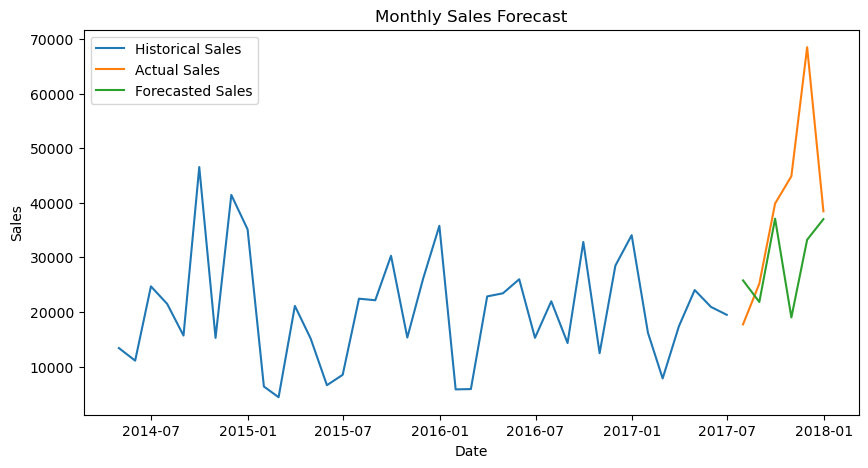

In [61]:
plt.figure(figsize=(10,5))
plt.plot(train['Order Date'], train['Total_Sales'], label='Historical Sales')
plt.plot(test['Order Date'], y_test, label='Actual Sales')
plt.plot(test['Order Date'], sarima_forecast, label='Forecasted Sales')

plt.title("Monthly Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [ ]:
# - Accuracy is a classification metric (used when predicting categories like “spam” vs “not spam”).
# - Sales forecasting is a regression problem (predicting continuous values like revenue or units sold).
# - That’s why metrics like MAE, RMSE, and MAPE are appropriate — they measure how close your numerical predictions are to the actual sales.
